In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load data
df = pd.read_csv('food_safety_training_data.csv')


In [18]:
# Separate numerical and categorical columns
numerical_cols = ['cooking_temperature', 'cooking_duration', 'storage_temperature', 
                  'humidity', 'safe_hours']
categorical_cols = ['cooking_method', 'container_type', 'ingredients']


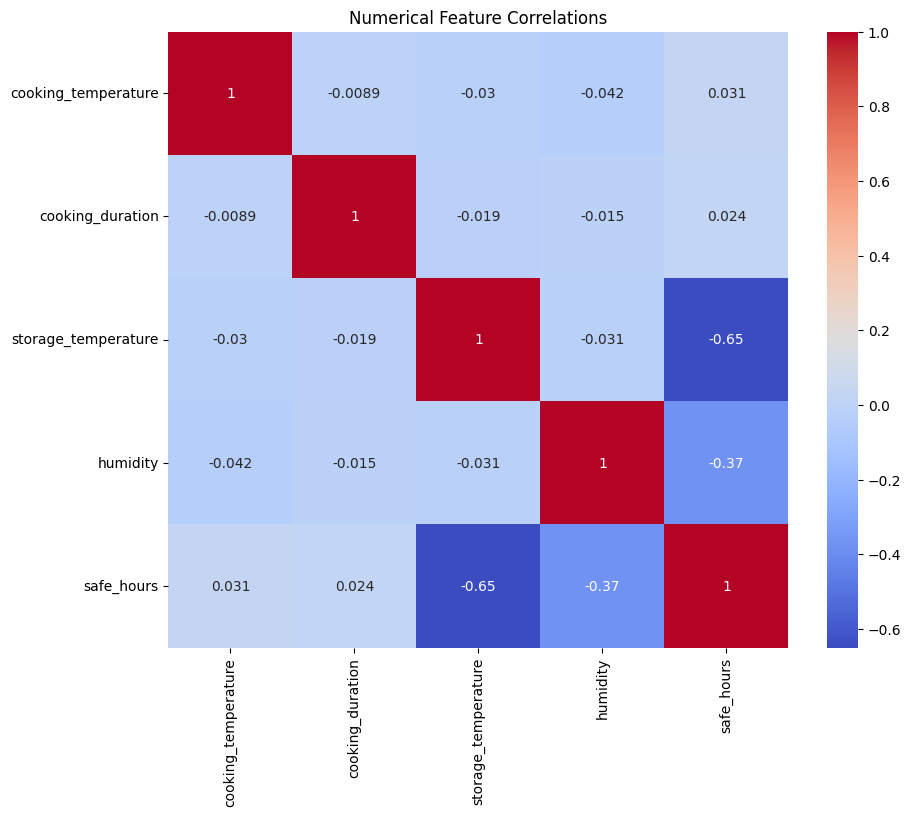

In [19]:
# Correlation analysis for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Numerical Feature Correlations')
plt.show()


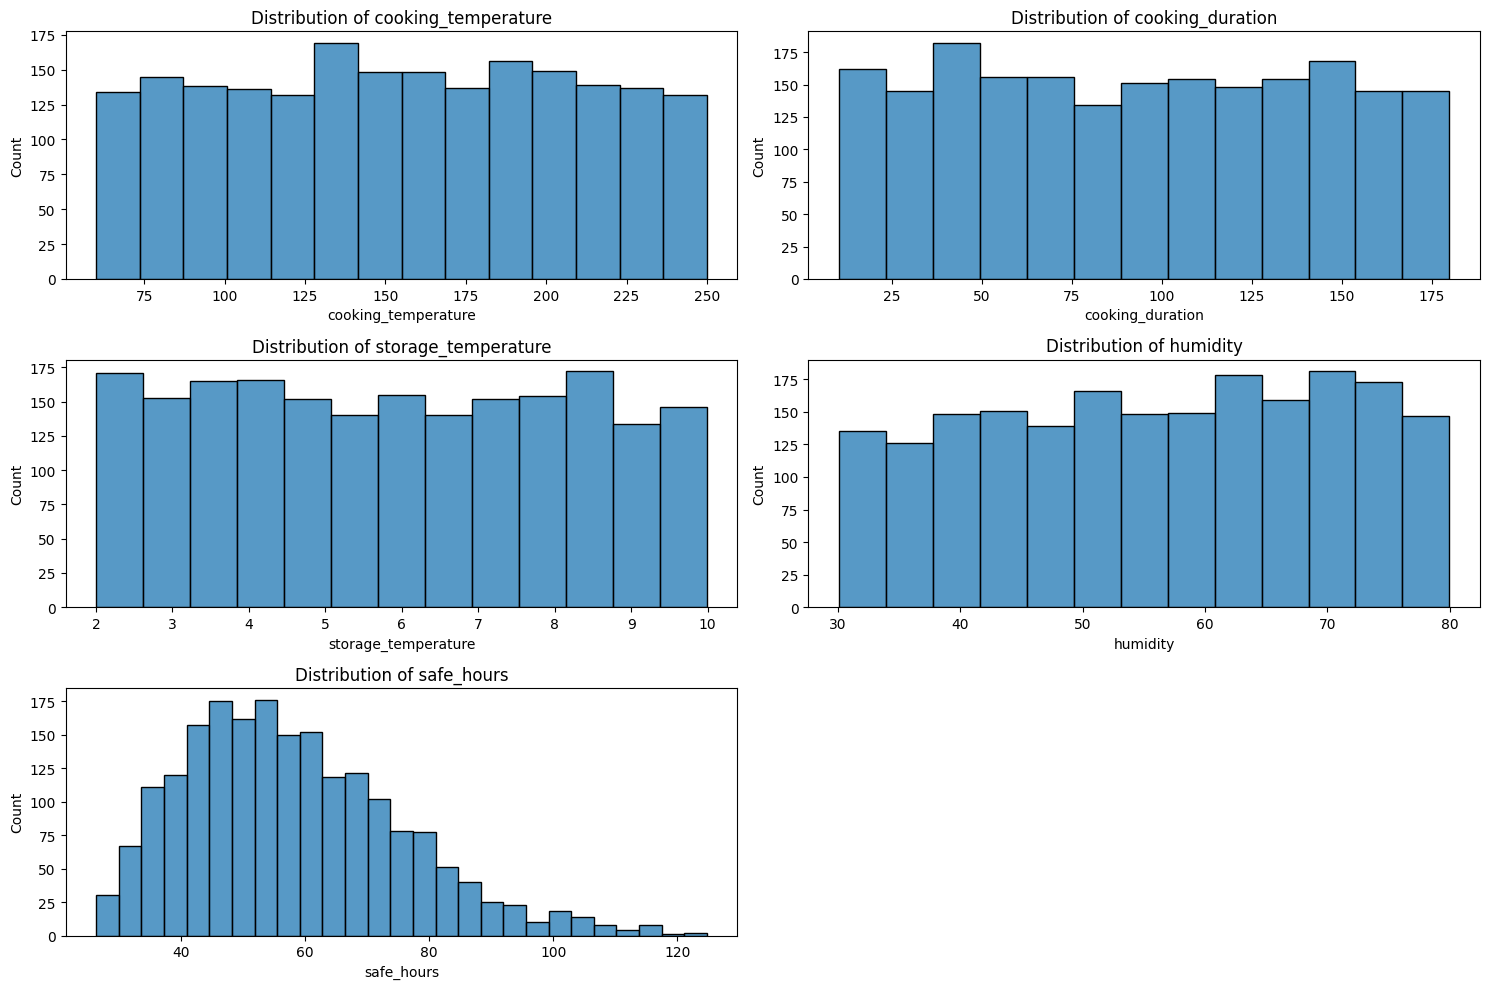

In [20]:
# Distribution plots for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


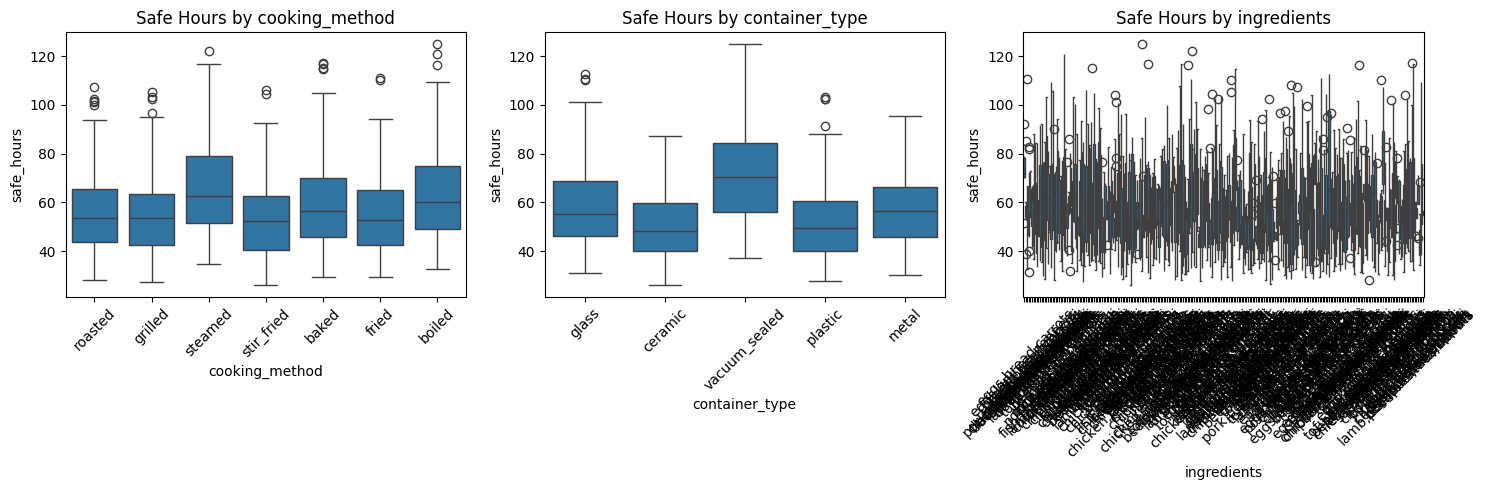

In [21]:
# Box plots for categorical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=col, y='safe_hours', data=df)
    plt.xticks(rotation=45)
    plt.title(f'Safe Hours by {col}')
plt.tight_layout()
plt.show()


In [22]:
# Model Training
X = df[numerical_cols[:-1] + categorical_cols].copy()
y = df['safe_hours']


In [23]:
# Encode categorical variables
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    X.loc[:, col] = encoders[col].fit_transform(X[col])


In [24]:
# Split and scale 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
# Train model
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
model.fit(X_train_scaled, y_train)


GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42)

In [26]:
# Evaluate
y_pred = model.predict(X_test_scaled)
metrics = {
    'R2 Score': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nModel Performance:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.3f}")



Model Performance:
R2 Score: 0.948
MAE: 3.145
RMSE: 3.958


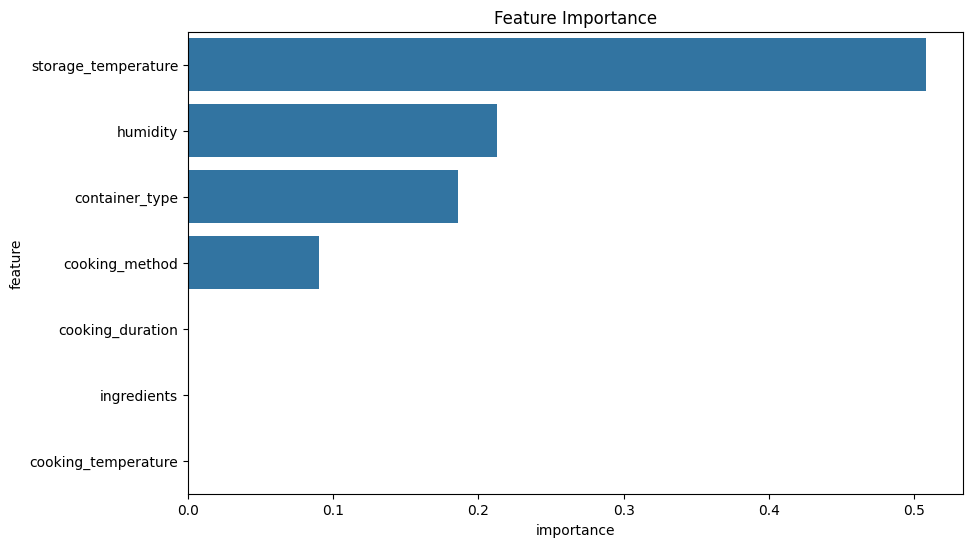

In [27]:
# Feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Feature Importance')
plt.show()


In [28]:
# Save model
model_artifacts = {
    'model': model,
    'scaler': scaler,
    'encoders': encoders,
    'feature_columns': list(X.columns),
    'numerical_cols': numerical_cols[:-1],
    'categorical_cols': categorical_cols
}
joblib.dump(model_artifacts, 'food_safety_model.joblib')


['food_safety_model.joblib']

In [31]:
# Example prediction function
def predict_safety(data):
    features = pd.DataFrame([data])
    for col in categorical_cols:
        if features[col].iloc[0] in encoders[col].classes_:
            features[col] = encoders[col].transform(features[col])
        else:
            # Assign a default value for unseen categories
            features[col] = -1
    features_scaled = scaler.transform(features)
    return model.predict(features_scaled)[0]
data = {
    'cooking_temperature': 150, 
    'cooking_duration': 30,
    'storage_temperature': 40,
    'humidity': 0.6,
    'cooking_method': 'boiling',
    'container_type': 'glass',
    'ingredients': 'vegetables'
}

safe_hours = predict_safety(data)
print(f"Predicted safe storage hours: {safe_hours:.2f}")

Predicted safe storage hours: 50.78
